## Analyse du mouvement d'une masse ponctuelle m dans le champ de gravitation créé par une masse M placée en O

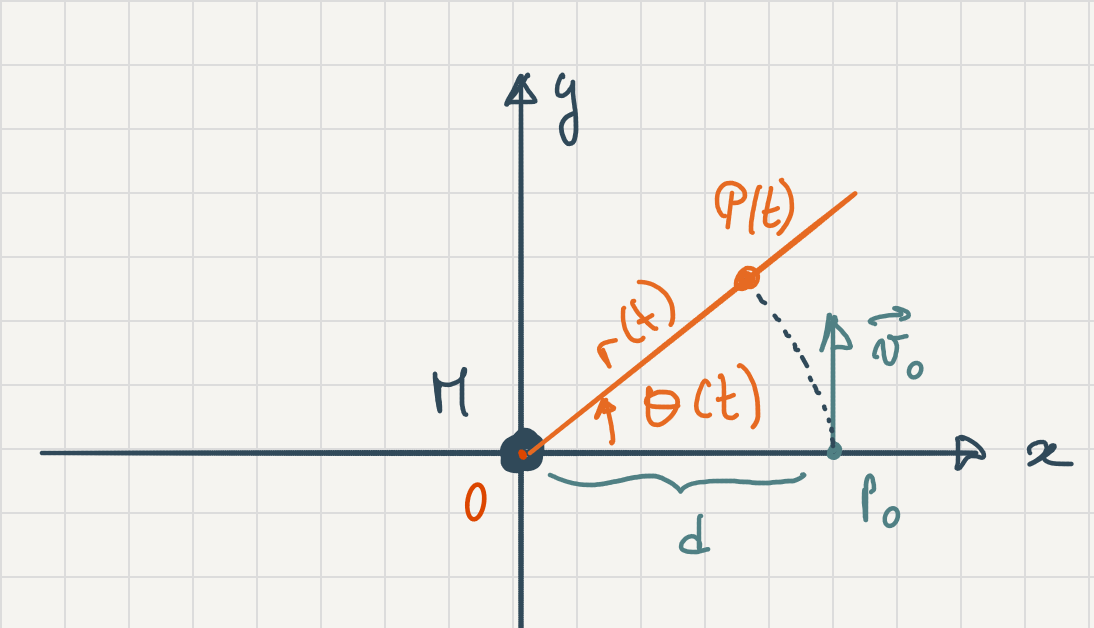

In [64]:
from IPython.display import Image
Image("Planetes1.png")

On considère une masse $M$ en $O$ qui exerce une force gravitationnelle sur un objet de masse $m$ placé initialement en $P_0$ avec la vitesse $\vec v_0$

On travaille en coordonnées polaires $\rho$, $\theta$. la masse $m$ se trouve à l'instant $t$ au point $P$ repéré par $\vec r(t)$ et $\theta (t

Masse centrale en O

On choisit $d$ et $v_0$ (valeurs initiales) et on "lance" l'objet. On observe sa trajectoire ainsi que les courbes d'énergie potentielle ; potentiellle effective et mécanique.

In [65]:
import numpy as np
from scipy.integrate import solve_ivp

from bokeh.io import output_notebook, push_notebook
from bokeh.models import ColumnDataSource, Arrow, NormalHead
from bokeh.models import CustomJS, Slider, Button, Toggle
from bokeh.models.widgets import DataTable, DateFormatter, TableColumn
from bokeh.models.markers import Asterisk
from bokeh.events import ButtonClick
from bokeh.models.markers import Cross
from bokeh.layouts import row, column
from bokeh.plotting import figure, show
import time
from pdb import set_trace
output_notebook()

Loading BokehJS ...

In [66]:
def compute_constants(r,v):
    h = np.cross(r,v)
    ep = 1./2*np.dot(v,v) - M/np.linalg.norm(r)

    if np.abs(ep)>1e-8:
        a = np.abs(-M/(2*ep))
    else:
        a = h**2/(2*M)
    e = np.sqrt(max(0,1+2*ep*h**2/M**2))
    
    return h, ep, a, e

def compute_theta_0():
    # ellipse: r = a(1-e**2)/(1+e*cos(theta))
    # hyperbola: r = a(e**2-1)/(1+e*cos(theta))
    # parabola: r=2a/(1+cos(theta))
    
    if e<1: 
        cos = (a*(1-e**2)/r_0-1)/e
    elif e>1: 
        cos = (a*(e**2-1)/r_0-1)/e
    else: 
        cos = 2*a/r_0-1
        
    # to overcome the roundoff error we have to make sure
    # that cosine is in [-1,1]
    if cos<0:
        cos = max(-1,cos)
    else:
        cos = min(1,cos)
    
    # the sign of r_dot determines the sign of sin(theta_0)
    r_dot_sign = np.dot(r0,v0)
    
    # knowing the value of cos and sign of sin, we can obtain
    # the true value of theta_0
    if r_dot_sign>0:
        return np.arccos(cos)
    else:
        return -np.arccos(cos)+np.pi*2

def compute_psi():
    """
    the main axis might not be inline with X-Y coordinate. The 
    inclination angle is called psi.
    """
    return np.arctan2(r0[1],r0[0]) - np.sign(h)* theta_0
    
def dy_dt(t,y):
    """
    y = [theta, r, r_dot]
    """
    
    theta_dot = abs(h)/y[1]**2
    r_dot = y[2]
    r_double_dot = -M/y[1]**2 + h**2/y[1]**3
    
    return [theta_dot, r_dot, r_double_dot]

def compute_trajectory():
#     h,ep, a, e = compute_constants(r0,v0)
#     r_0 = np.linalg.norm(r0)
#     theta_0 = compute_theta_0()
#     psi = compute_psi()
    i_max=200
    if e<1:
        th_ = np.linspace(0,2*np.pi+0.01, i_max)
        r_ = a*(1-e**2)/(1+e*np.cos(th_))
    else:
        th_ = np.linspace(-np.arccos(-1./e)*.98,np.arccos(-1./e)*.98,i_max)
        if e>1:
            r_ = a*(e**2-1)/(1+e*np.cos(th_))
        else:
            r_ = 2*a/(1+np.cos(th_))
    
    return r_*np.cos(np.sign(h)*th_+psi),r_*np.sin(np.sign(h)*th_+psi)

In [67]:
r0 = np.array([-0.4,0.5])
v0= np.array([.5,0])
m=1
M=0.1

In [68]:
h,ep, a, e = compute_constants(r0,v0)
if ep<0:
    T = np.sqrt(4*np.pi**2*a**3/(M))
else:
    T=10
dt= 0.05

# initial conditions
r_0 = np.linalg.norm(r0)
theta_0 = compute_theta_0()
psi = compute_psi()

traj_x, traj_y = compute_trajectory()

r_dot_0 = (2.*(np.sin(theta_0)>0)-1)*np.sqrt(np.abs(2*(ep + M*1./r_0)- (h/r_0)**2))
w0 = [ theta_0, r_0, r_dot_0 ]

# solving the equation
abserr = 1.0e-8
relerr = 1.0e-8
wsol = solve_ivp(dy_dt, t_span=[0,T+dt], y0= w0, t_eval= np.arange(0,T+dt,dt), max_step = dt, atol=abserr, rtol=relerr)

In [69]:
X = wsol.y[1,:]*np.cos(np.sign(h)*wsol.y[0,:]+psi)
Y = wsol.y[1,:]*np.sin(np.sign(h)*wsol.y[0,:]+psi)
t = wsol.t[0]

rs_ = np.linspace(0.05,10,1000)
V_ = -M/rs_
Vh_= 0.5*h**2/rs_**2
Veff_ = V_ + Vh_

# making the sources
txt = ColumnDataSource(data={'ep':['%+.4f'%ep], 'h':['%+.4f'%h], 'a':['%+.4f'%a], 'e':['%+.4f'%e]})
constant = ColumnDataSource(data={'ep':[ep], 'h':[h], 'a':[a], 'e':[e]})
solution = ColumnDataSource(data={'X':[X[0]], 'Y':[Y[0]]})
initials = ColumnDataSource(data={'begin_x':[0], 'begin_y':[0],\
                                  'end_x':[X[0]], 'end_y':[Y[0]],\
                                  'end_vx':[X[0]+v0[0]],'end_vy':[Y[0]+v0[1]]})
position = ColumnDataSource(data={'begin_x':[0], 'begin_y':[0],\
                                  'end_x':[X[0]], 'end_y':[Y[0]],'theta':[theta_0],\
                                  'end_vx':[X[0]+v0[0]],'end_vy':[Y[0]+v0[1]]})
trajectory = ColumnDataSource(data={'x':traj_x, 'y':traj_y})
energies = ColumnDataSource(data={'V' : V_, 'V_eff':Veff_, 'V_h':Veff_-V_,
                                  'r': rs_, 'ep':np.ones_like(rs_)*ep, 'ZERO':np.zeros_like(rs_)})#'K' : [K_], 'K_eff' : [Keff_], 
specific_points = ColumnDataSource(data={'pe_x':[a*np.abs(1-e)*np.cos(psi)], 'pe_y':[a*np.abs(1-e)*np.sin(psi)],\
                                         'ap_x':[a*(1+e)*np.cos(psi+np.pi)],'ap_y':[a*(1+e)*np.sin(psi+np.pi)],\
                                         'ap':[a*np.abs(1-e)], 'pe':[a*(1+e)], 'energy':[ep]})
if e>1: 
    specific_points.data['ap_x']=[1000*(1+e)*np.cos(psi+np.pi)]
    specific_points.data['ap_y']=[1000*(1+e)*np.sin(psi+np.pi)]
    specific_points.data['pe']=[1000*(1+e)]
# plot setup
arrow_setting = NormalHead(line_color="gray", line_width=3, size=6, fill_color='gray', fill_alpha=1)
arrow_init_setting = NormalHead(line_color="red", line_width=1, size=6, fill_color='red', fill_alpha=0.5)
range_lim = 1.2*max(max(np.abs(X)), max(np.abs(Y)))
range_r = 0, 1.2*np.sqrt(max(Y**2+X**2))
range_eff = -(M/h)**2, 1.2*np.abs(ep)
range_e = -1.2*(M/h)**2*(1+np.sqrt(1+2*ep*(h/M)**2)), 0.2*np.abs(ep)


# plot
plot = figure(title ='Time: %.3f' %(t/T), x_range=(-range_lim,range_lim), y_range=(-range_lim,range_lim),plot_height=450,plot_width=450,)
plot_Veff = figure(title = 'Effective Potential Energy', x_range=(-1,10), y_range=range_eff , plot_height=300,plot_width=500, )

# points, lines and arrow
sun = plot.circle(0,0,color='black',)
ap_glyph_traj = Asterisk(x="ap_x", y="ap_y", fill_color='cyan', line_color='cyan', size=15)
pe_glyph_traj = Asterisk(x="pe_x", y="pe_y", fill_color='orange', line_color='orange', size=15)
plot.add_glyph(specific_points, ap_glyph_traj)
plot.add_glyph(specific_points, pe_glyph_traj)

# pe = plot.cross('pe_x','pe_y',color='orange',source=specific_points, size=12, )
# ap = plot.cross('ap_x','ap_y',color='orange',source=specific_points, size=12, )
# planet = plot.circle('end_x','end_y',color='blue',source=position, size=8)
planet_ini = plot.circle('end_x','end_y',color='red',source=initials, size=8,)
# plot.line('X', 'Y', line_width=3, line_alpha=0.5, source=solution, )
plot.line('x', 'y' , line_width=2, line_alpha=0.5, line_dash='dashed', color='navy', source= trajectory)
arrow = Arrow(x_start='begin_x', y_start='begin_y', x_end='end_x', y_end='end_y', end=arrow_setting, source=position)
arrow_r = Arrow(x_start='begin_x', y_start='begin_y', x_end='end_x', y_end='end_y', end=arrow_init_setting, source=initials, line_color='red')
arrow_v = Arrow(x_start='end_x', y_start='end_y', x_end='end_vx', y_end='end_vy', end=arrow_init_setting, source=initials, line_color='red')
# plot.add_layout(arrow)
plot.add_layout(arrow_r)
plot.add_layout(arrow_v)

# energy graphs
plot_Veff.line('r','V_eff',source=energies, color='blue', line_width=3,)
plot_Veff.line('r','V_h',source=energies, color='green')
plot_Veff.line('r','V',source=energies, color='green')
plot_Veff.line('r','ZERO',source=energies, color='black')
plot_Veff.line('r','ep',source=energies, color='red')
ap_glyph = Asterisk(x="ap", y="energy", fill_color='cyan', line_color='cyan', size=15)
pe_glyph = Asterisk(x="pe", y="energy", fill_color='orange', line_color='orange', size=15)
plot_Veff.add_glyph(specific_points, ap_glyph)
plot_Veff.add_glyph(specific_points, pe_glyph)

column_txt = [TableColumn(field="h", title="Angular momentum"),TableColumn(field="ep", title="Energy"),\
              TableColumn(field="a", title="Major semi-axis"),TableColumn(field="e", title="Eccentricity")]
data_table = DataTable(source=txt, columns=column_txt, width=450, height=140 )

slider_rx = Slider(start=-10, end=10, value=r0[0], step=.05, title=r'$r_x$')
slider_ry = Slider(start=-10, end=10, value=r0[1], step=.05, title=r'$r_y$')
slider_vx = Slider(start=-10, end=10, value=v0[0], step=.05, title=r'$v_x$')
slider_vy = Slider(start=-10, end=10, value=v0[1], step=.05, title=r'$v_y$')

callback = CustomJS(args=dict(trajectory=trajectory, initials=initials, constant=constant, energies=energies,specific_points=specific_points, txt=txt,\
                              slider_rx=slider_rx, slider_ry= slider_ry, slider_vx=slider_vx, slider_vy=slider_vy,\
                              arrow_r=arrow_r, arrow_v=arrow_v, xr= plot.x_range, yr= plot.y_range),
                    code="""
    const rx = slider_rx.value;
    const ry = slider_ry.value;
    const vx = slider_vx.value;
    const vy = slider_vy.value;
    
    const traj = trajectory.data;
    const pos = initials.data;
    const con = constant.data;
    const erergy= energies.data;
    const points = specific_points.data;
    const con_txt = txt.data;
    
    var x = traj['x'];
    var y = traj['y'];
    pos['end_x'] = [rx];
    pos['end_y'] = [ry];
    pos['end_vx'] = [rx+vx];
    pos['end_vy'] = [ry+vy];
    
    var M=0.1;
    
    var r = Math.sqrt(rx*rx + ry*ry);
    var v = Math.sqrt(vx*vx + vy*vy);
    
    var h = rx*vy-ry*vx;
    var ep = 1./2*(v*v) - M/r;
    var e = Math.sqrt(Math.max(0, 1+2*ep*h*h/(M*M)));
    if (Math.abs(ep)>1e-6) {
        var a = Math.abs(-M/(2*ep));
    } else {
        var a = h*h/(2*M);
    }
    
    // writing the new constants of motion
    con.data = {'ep':[ep], 'h':[h], 'a':[a], 'e':[e]}
    
    // writing constants on table
    var plus_str = "+"
    con_txt['e'] = [plus_str.concat(e.toFixed(4).toString())];
    con_txt['a'] = [plus_str.concat(a.toFixed(4).toString())];
    if (ep>0){
        con_txt['ep'] = [plus_str.concat(ep.toFixed(4).toString())];
    } else {
        con_txt['ep'] = [ep.toFixed(4).toString()];
    }
    if (h>0){
        con_txt['h'] = [plus_str.concat(h.toFixed(4).toString())];
    } else {
        con_txt['h'] = [h.toFixed(4).toString()];
    }
    
    
    // computing the convenient range for potential plot
    var r_min = Math.min(0.01, 0.25*h*h/M);
    if (e<0){
        var r_max = Math.min(5*a*(1+e),10);
    } else {
        var r_max = 10;
    }
    
    var Veff_ = erergy['V_eff'];
    var V_ = erergy['V'];
    var Vh_ = erergy['V_h'];
    var rs_ = erergy['r'];
    var ep_ = erergy['ep'];
    for (var i = 0; i < rs_.length; i++) {
        rs_[i] = r_min+i/(r_max-r_min);
        V_[i] = -M/rs_[i];
        Vh_[i] = 0.5*h*h/(rs_[i]*rs_[i]);
        Veff_[i] = V_[i]+Vh_[i];
        ep_[i] = ep;
        } 
    
    
    // theta_0
    if (e<1){
        cos = (a*(1-e*e)/r-1)/e;
    } else if (e>1){ 
        cos = (a*(e*e-1)/r-1)/e;
    } else { 
        cos = 2*a/r-1;
    }
    // round-off hack
    if (cos<0){
        cos = Math.max(-1, cos);
    } else {
        cos = Math.min(1,cos);
    }
    var r_dot_sign = rx*vx + ry*vy;
    if (r_dot_sign>0) {
        var theta_0 = Math.acos(cos);
    } else {
        var theta_0 = -Math.acos(cos)+Math.PI*2;
    }
    
    //psi
    var psi = Math.atan2(ry,rx) - ((0>h)?-1:1)* theta_0;
    
    var th_start = 0;
    var th_end = 2*Math.PI;
    if (e>1){
        th_start = -Math.acos(-1/e);
        th_end = Math.acos(-1/e);
    }
    dth = th_end-th_start;
    var R = [];
    i_max = 200
    for (var i = 0; i < i_max; i++) {
        if (e<1){
            R[i] = a*(1-e*e)/(1+e*Math.cos(th_start+i/i_max*dth));
        } else if (e>1){ 
            R[i] = a*(e*e-1)/(1+e*Math.cos(th_start+i/i_max*dth));
        } else { 
            R[i] = 2*a/(1+Math.cos(th_start+i/i_max*dth));
        }
    }
    
    var _max = 0
    for (var i = 0; i < i_max; i++) {
        x[i] = R[i]*Math.cos( ((0>h)?-1:1)* (th_start+i/i_max*dth) + psi);
        y[i] = R[i]*Math.sin( ((0>h)?-1:1)* (th_start+i/i_max*dth) + psi);
        _max = Math.max(Math.abs(x[i]), Math.abs(y[i]), _max);
        }
    
    if (e<1){
        points['pe_x'][0] = a*(1-e)*Math.cos(psi);
        points['pe_y'][0] = a*(1-e)*Math.sin(psi);
        points['ap_x'][0] = a*(1+e)*Math.cos(psi+ Math.PI);
        points['ap_y'][0] = a*(1+e)*Math.sin(psi+ Math.PI);
        points['ap'][0] = a*(1+e);
    } else {
        points['pe_x'][0] = a*(e-1)*Math.cos(psi);
        points['pe_y'][0] = a*(e-1)*Math.sin(psi);
        points['ap_x'][0] = 1000*a*(1+e)*Math.cos(psi+ Math.PI);
        points['ap_y'][0] = 1000*a*(1+e)*Math.cos(psi+ Math.PI);
        points['ap'][0] = 1000*a*(1+e);
    }
    points['pe'][0] = a*Math.abs(e-1);
    points['energy'][0] = ep;
    
    //xr.start = -1.2*_max
    //xr.end = 1.2*_max
    //yr.start = -1.2*_max
    //yr.end = 1.2*_max
    arrow_r.change.emit();
    arrow_v.change.emit();
    trajectory.change.emit();
    initials.change.emit();
    energies.change.emit();
    constant.change.emit();
    specific_points.change.emit();
    txt.change.emit();
""")

slider_rx.js_on_change('value', callback)
slider_ry.js_on_change('value', callback)
slider_vx.js_on_change('value', callback)
slider_vy.js_on_change('value', callback)

### UNCOMMENT THIS FOR ANIMATION
# planet = plot.circle('end_x','end_y',color='blue',source=position, size=8)
# plot.line('X', 'Y', line_width=3, line_alpha=0.5, source=solution, )
# plot.add_layout(arrow)
#######

# layout setup
layout= row(column(plot,slider_rx, slider_ry), column(plot_Veff, data_table, slider_vx, slider_vy))#,plot_V), column(plot_Keff,plot_K))
handle= show(layout, notebook_handle=True );
# push_notebook(handle=handle)

### UNCOMMENT THE BLOCK BELOW FOR ANIMATION
# idx=0
# while (t<=T):
#     idx+=1
#     t = wsol.t[idx]
#     if np.abs(T-t)<=np.diff(wsol.t).max():
#         if ep<0:
#             idx=0
#             t= wsol.t[idx]
#         else:
#             break

#     new_data = {'X': [X[idx]], 'Y': [Y[idx]]}
#     solution.stream(new_data, len(X))

#     r_ = np.sqrt(X[idx]**2+Y[idx]**2)
#     V_ = -M/r_
#     K_ = ep - V_
#     Veff_ = V_ + 0.5*h**2/r_**2
#     Keff_ = ep - Veff_


#     energies.data = {'K' : [K_], 'K_eff' : [Keff_],
#                     'V' : [V_], 'V_eff':[Veff_], 'r':[r_]}

#     position.patch({'end_x' : [(0, X[idx]) ],
#                     'end_y' : [(0, Y[idx])],
#                     'theta' : [(0, np.arctan2(Y[idx],X[idx]))]
#                     })

#     plot.title.text = 'Time: {0:.2f}'.format(t/T)
#     push_notebook(handle=handle)
#     time.sleep(0.05)
########